# IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils as np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential
from keras.layers.recurrent import SimpleRNN
from sklearn.metrics import precision_recall_fscore_support as score

In [3]:
Email_Data = pd.read_csv('DATA/SMSSpamCollection.txt', sep='\t', header=None, names=['Target', 'Email'])
Email_Data.head()

,Target,Email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# DATA PREPROCESS

In [4]:
#lowercase
Email_Data['Email'] = Email_Data['Email'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# stopword filtering
stop = stopwords.words('english')
Email_Data['Email'] = Email_Data['Email'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#stemming
st = PorterStemmer()
Email_Data['Email'] = Email_Data['Email'].apply(lambda x: " ".join ([st.stem(word) for word in x.split()]))
#lemmatize
Email_Data['Email'] = Email_Data['Email'].apply(lambda x: " ".join ([Word(word).lemmatize() for word in x.split()]))
Email_Data.head()

,Target,Email
0,ham,"go jurong point, crazy.. avail bugi n great wo..."
1,ham,ok lar... joke wif u oni...
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor... u c alreadi say...
4,ham,"nah think goe usf, live around though"


<AxesSubplot:>

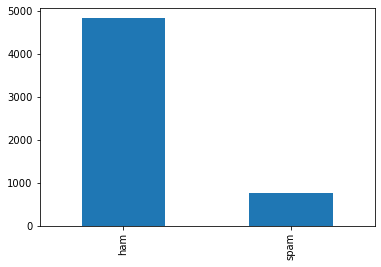

In [5]:
result=Email_Data['Target'].value_counts()
result.plot(kind='bar')

In [6]:
#Train Test Split
train, test = train_test_split(Email_Data[['Email', 'Target']] , test_size=0.2)
print(f"shape of train: {train.shape}")
print(f"shape of test: {test.shape}")

shape of train: (4457, 2)
shape of test: (1115, 2)


In [7]:
MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000

# tokenize
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train.Email)
train_sequences = tokenizer.texts_to_sequences(train.Email)
test_sequences = tokenizer.texts_to_sequences(test.Email)

In [8]:
# dictionary containing words and their index
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7586 unique tokens.


In [11]:
# get only the top frequent words on train
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
# get only the top frequent words on test
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(f"shape of train_data: {train_data.shape}")
print(f"shape of test_data: {test_data.shape}")

shape of train_data: (4457, 300)
shape of test_data: (1115, 300)


In [12]:
train_labels = train['Target']
test_labels = test['Target']

In [13]:
# LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

In [14]:
# Count Of Unique Class
print(le.classes_)
print(f"Unique Class For Train: {np.unique(train_labels, return_counts=True)}")
print(f"Unique Class For Test: {np.unique(test_labels, return_counts=True)}")

['ham' 'spam']
Unique Class For Train: (array([0, 1]), array([3874,  583], dtype=int64))
Unique Class For Test: (array([0, 1]), array([951, 164], dtype=int64))


In [15]:
# changing data types
labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print(f'Shape of data tensor: {train_data.shape}')
print(f'Shape of label tensor: {labels_train.shape}')
print(f'Shape of label tensor: {labels_test.shape}')

Shape of data tensor: (4457, 300)
Shape of label tensor: (4457, 2)
Shape of label tensor: (1115, 2)


In [16]:
EMBEDDING_DIM = 100
print(MAX_SEQUENCE_LENGTH)

300


# CREATE CNN MODEL

In [17]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [19]:
model.fit(train_data, labels_train ,validation_data=(test_data, labels_test), batch_size=64, epochs=5)

Epoch 1/5
70/70 [==============================] - 15s 200ms/step - loss: 0.3808 - accuracy: 0.8481 - val_loss: 0.6164 - val_accuracy: 0.8529
Epoch 2/5
70/70 [==============================] - 13s 192ms/step - loss: 0.1506 - accuracy: 0.9468 - val_loss: 1.0792 - val_accuracy: 0.8529
Epoch 3/5
70/70 [==============================] - 14s 198ms/step - loss: 0.0610 - accuracy: 0.9838 - val_loss: 1.3873 - val_accuracy: 0.8529
Epoch 4/5
70/70 [==============================] - 14s 197ms/step - loss: 0.0335 - accuracy: 0.9921 - val_loss: 1.3116 - val_accuracy: 0.8529
Epoch 5/5
70/70 [==============================] - 14s 206ms/step - loss: 0.0210 - accuracy: 0.9946 - val_loss: 1.2339 - val_accuracy: 0.8529


In [21]:
evaluate = model.evaluate(test_data, labels_test) 
print(f"Accuracy Convolution: {evaluate[1]*100}")

35/35 [==============================] - 1s 19ms/step - loss: 1.2339 - accuracy: 0.8529
Accuracy Convolution: 85.2914810180664


# CREATE RNN MODEL

In [22]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SimpleRNN(2, input_shape=(None,1)))
model.add(Dense(2,activation='softmax'))

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [24]:
model.fit(train_data, labels_train ,validation_data=(test_data, labels_test), batch_size=16, epochs=5)

Epoch 1/5
279/279 [==============================] - 26s 89ms/step - loss: 0.4840 - accuracy: 0.8981 - val_loss: 0.4059 - val_accuracy: 0.9022
Epoch 2/5
279/279 [==============================] - 25s 88ms/step - loss: 0.2872 - accuracy: 0.9605 - val_loss: 0.3173 - val_accuracy: 0.9256
Epoch 3/5
279/279 [==============================] - 25s 89ms/step - loss: 0.1780 - accuracy: 0.9814 - val_loss: 0.2822 - val_accuracy: 0.9184
Epoch 4/5
279/279 [==============================] - 25s 89ms/step - loss: 0.1122 - accuracy: 0.9906 - val_loss: 0.2519 - val_accuracy: 0.9238
Epoch 5/5
279/279 [==============================] - 25s 88ms/step - loss: 0.0789 - accuracy: 0.9946 - val_loss: 0.2580 - val_accuracy: 0.9139


In [25]:
evaluate = model.evaluate(test_data, labels_test) 
print(f"Accuracy Convolution: {evaluate[1]*100}")

35/35 [==============================] - 1s 16ms/step - loss: 0.2580 - accuracy: 0.9139
Accuracy Convolution: 91.39013290405273


In [26]:
# prediction on test data
predicted_Srnn=model.predict(test_data)
predicted_Srnn

array([[9.9919325e-01, 8.0679148e-04],
       [9.9945825e-01, 5.4177974e-04],
       [9.9896061e-01, 1.0394339e-03],
       ...,
       [9.9598444e-01, 4.0155533e-03],
       [9.9784601e-01, 2.1540474e-03],
       [9.9938500e-01, 6.1496755e-04]], dtype=float32)

In [28]:
#model evaluation
import sklearn
precision, recall, fscore, support = score(labels_test, predicted_Srnn.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test, predicted_Srnn.round()))

precision: [0.93138244 0.77419355]
recall: [0.97055731 0.58536585]
fscore: [0.95056643 0.66666667]
support: [951 164]
############################
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       951
           1       0.77      0.59      0.67       164

   micro avg       0.91      0.91      0.91      1115
   macro avg       0.85      0.78      0.81      1115
weighted avg       0.91      0.91      0.91      1115
 samples avg       0.91      0.91      0.91      1115



# CREATE LSTM MODEL

In [33]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [34]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [35]:
model.fit(train_data, labels_train ,validation_data=(test_data, labels_test), batch_size=16, epochs=5)

Epoch 1/5
279/279 [==============================] - 40s 136ms/step - loss: 0.1103 - accuracy: 0.9652 - val_loss: 0.3568 - val_accuracy: 0.9874
Epoch 2/5
279/279 [==============================] - 37s 133ms/step - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.0826 - val_accuracy: 0.9865
Epoch 3/5
279/279 [==============================] - 38s 135ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0825 - val_accuracy: 0.9848
Epoch 4/5
279/279 [==============================] - 37s 133ms/step - loss: 6.1157e-04 - accuracy: 0.9998 - val_loss: 0.0842 - val_accuracy: 0.9848
Epoch 5/5
279/279 [==============================] - 39s 141ms/step - loss: 2.4325e-04 - accuracy: 1.0000 - val_loss: 0.1214 - val_accuracy: 0.9865


In [38]:
evaluate = model.evaluate(test_data, labels_test) 
print(f"Accuracy Convolution: {evaluate[1]*100}")

35/35 [==============================] - 2s 44ms/step - loss: 0.1214 - accuracy: 0.9865
Accuracy Convolution: 98.65471124649048


In [36]:
#prediction on text data
predicted_lstm=model.predict(test_data)
predicted_lstm

array([[1.000000e+00, 6.667492e-22],
       [1.000000e+00, 7.282981e-19],
       [1.000000e+00, 8.028914e-12],
       ...,
       [1.000000e+00, 3.062356e-11],
       [9.999999e-01, 9.280084e-08],
       [1.000000e+00, 9.604310e-13]], dtype=float32)

In [37]:
precision, recall, fscore, support = score(labels_test, predicted_lstm.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print("############################")
print(sklearn.metrics.classification_report(labels_test,predicted_lstm.round()))

precision: [0.98447205 1.        ]
recall: [1.         0.90853659]
fscore: [0.99217527 0.95207668]
support: [951 164]
############################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       951
           1       1.00      0.91      0.95       164

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115
 samples avg       0.99      0.99      0.99      1115

